In [28]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '/media/pklein/SATA_SSD/GitHub/pypsa_utilities/eskom data/')
sys.path.insert(1, '/mnt/wsl/PHYSICALDRIVE0p1/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 

from pypsa.descriptors import (
    Dict,
    additional_linkports,
    expand_series,
    get_active_assets,
    get_activity_mask,
    get_bounds_pu,
    get_extendable_i,
    get_non_extendable_i,
    nominal_attrs,
)

%run ../scripts/_helpers.py

In [29]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [39]:
n = pypsa.Network('../results/networks/solved_validation-4_RSA_redz_lcopt_LC-4380SEG.nc')

INFO:pypsa.io:Imported network solved_validation-4_RSA_redz_lcopt_LC-4380SEG.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [46]:
n1 = pypsa.Network('../results/networks/solved_validation-4_RSA_redz_lcopt_LC-3000SEG.nc')

INFO:pypsa.io:Imported network solved_validation-4_RSA_redz_lcopt_LC-3000SEG.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [47]:
n2 = pypsa.Network('../results/networks/solved_validation-4_RSA_redz_lcopt_LC.nc')

INFO:pypsa.io:Imported network solved_validation-4_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [50]:
def aggregate_capacity(n):
    capacity=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
    carriers=n.generators.carrier.unique()
    carriers = carriers[carriers !='load_shedding']
    for y in n.investment_periods:
        capacity.loc[carriers,y]=n.generators.p_nom_opt[(n.get_active_assets('Generator',y))].groupby(n.generators.carrier).sum()

    carriers=n.storage_units.carrier.unique()
    for y in n.investment_periods:
        capacity.loc[carriers,y]=n.storage_units.p_nom_opt[(n.get_active_assets('StorageUnit',y))].groupby(n.storage_units.carrier).sum()

    capacity.loc['OCGT',:]+=capacity.loc['gas',:]+capacity.loc['diesel',:]
    capacity=capacity.interpolate(axis=1)
    capacity=capacity.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','onwind','CSP','solar','battery'])

    return capacity

In [71]:
def aggregate_energy(n):
    def aggregate_p(n,y):
        return pd.concat(
            [
                n.generators_t.p.mul(n.snapshot_weightings['objective'],axis=0).loc[y].sum().groupby(n.generators.carrier).sum(),
                n.storage_units_t.p_dispatch.mul(n.snapshot_weightings['objective'],axis=0).loc[y].sum().groupby(n.storage_units.carrier).sum(),
            ]
        )
    energy=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
    carriers=n.generators.carrier.unique()
    #carriers = carriers[carriers !='load_shedding']
    for y in n.investment_periods:
        energy.loc[:,y]=aggregate_p(n,y)
    energy = energy.interpolate(axis=1)
    energy=energy.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','onwind','CSP','solar','battery'])

    return energy

In [78]:
cap = aggregate_capacity(n)
cap1 = aggregate_capacity(n1)
cap2 = aggregate_capacity(n2)

en = aggregate_energy(n)
en1 = aggregate_energy(n1)
en2 = aggregate_energy(n2)

<AxesSubplot: >

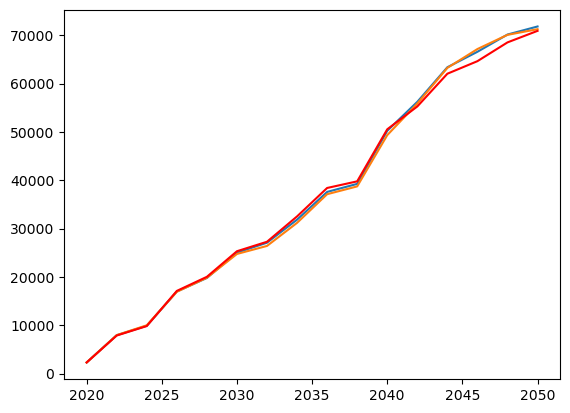

In [80]:
tech = 'solar'
cap.loc[tech].plot()
cap1.loc[tech].plot()
cap2.loc[tech].plot(color='r')


<AxesSubplot: >

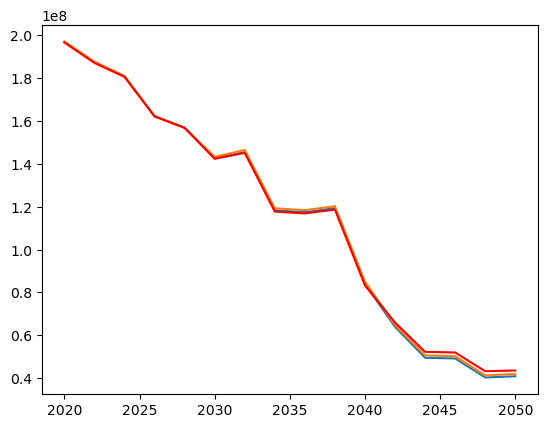

In [76]:
tech = 'coal'
en.loc[tech].plot()
en1.loc[tech].plot()
en2.loc[tech].plot(color='r')


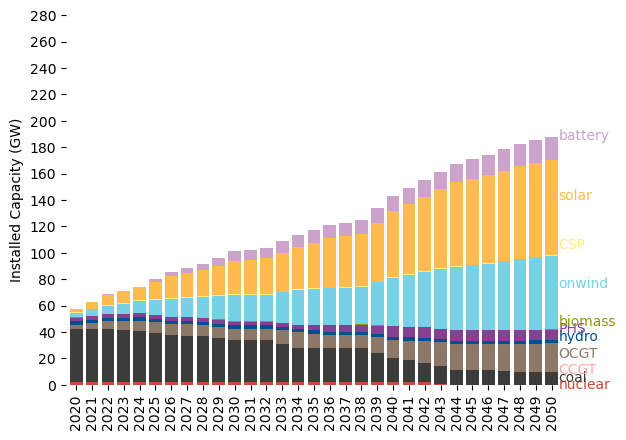

In [42]:
ax = (capacity/1000).T.plot.bar(stacked=True,color=colour_map,width=0.8)
plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,280])
plt.yticks(range(0, 280+1, 20))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

cnt=0
height = 0     
dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
for bar in ax.containers:
    end_cap = (capacity/1000).iloc[cnt,-1]
    x = len(capacity.T)-1
    y = end_cap/2+height+dy*cnt  # adjust y position based on index of the bar
    ax.annotate(
        capacity.index[cnt],
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        color=ax.containers[cnt][-1].get_facecolor(),
        #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
    )
    height += end_cap
    cnt+=1

ax.legend().set_visible(False)

#ax.grid(axis='y', color='lightgray',linestyle='-.',zorder=0)  # add light grey horizontal grid lines only


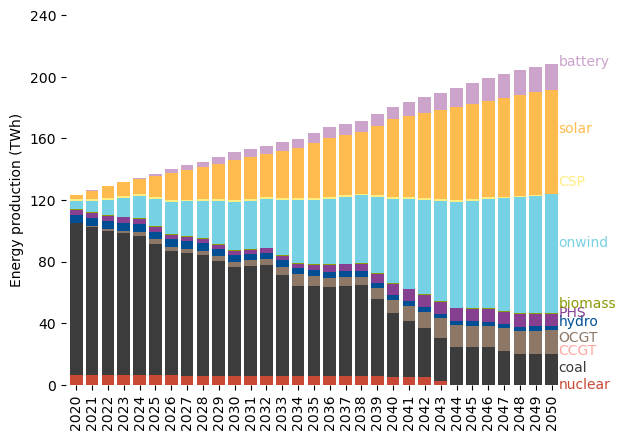

In [44]:
ax = (energy/1e6).T.plot.bar(stacked=True,color=colour_map,width=0.8)
plt.ylabel('Energy production (TWh)')
plt.xlabel("")
plt.ylim([0,240])
plt.yticks(range(0, 240+1, 40))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

cnt=0
height = 0     
dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
for bar in ax.containers:
    end_cap = (energy/1e6).iloc[cnt,-1]
    x = len(energy.T)-1
    y = end_cap/2+height+dy*cnt  # adjust y position based on index of the bar
    ax.annotate(
        capacity.index[cnt],
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        color=ax.containers[cnt][-1].get_facecolor(),
        #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
    )
    height += end_cap
    cnt+=1

ax.legend().set_visible(False)

#ax.grid(axis='y', color='lightgray',linestyle='-.',zorder=0)  # add light grey horizontal grid lines only


In [20]:
period_weighting = n.investment_period_weightings["years"]
weightings = n.snapshot_weightings.mul(period_weighting, level=0, axis=0).loc[
    n.snapshots
]
em_pu = n.generators.carrier.map(n.carriers.co2_emissions)
em_pu = (
    weightings["generators"].to_frame("weightings")
    @ em_pu.to_frame("weightings").T
)
emissions = em_pu.mul(n.generators_t.p/n.generators.efficiency).groupby(n.generators_t.p.index.get_level_values(0)).sum().sum(axis=1)
emissions

period
2019    2.379157e+08
2020    2.375836e+08
2021    2.260001e+08
2022    2.254793e+08
2023    2.177197e+08
2024    2.150781e+08
2025    1.969436e+08
2026    1.946480e+08
2027    1.938609e+08
2028    1.887482e+08
2029    1.741037e+08
2030    8.542119e+08
2035    7.016633e+08
2040    5.304086e+08
2045    3.580575e+08
2050    3.180446e+08
dtype: float64

In [ ]:
emissions.sum()/1e9

In [ ]:
eskom_data['loadshed_mlr'].groupby(eskom_data.index.year).sum().to_clipboard()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 


for y in [2017,2018,2019,2020,2021,2022]:
    data=df.loc['Generation Total','PCLF %']
    plt.plot(data[data.index.year==y].values)



In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

In [ ]:
stations

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0).unique()
eaf=pd.DataFrame(0,index=stations,columns=range(2017,2023))
planned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
unplanned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    eaf.loc[s,:]=df.loc[s,'EAF %'].groupby(df.loc[s,'EAF %'].index.year).mean()
    planned.loc[s,:]=df.loc[s,'PCLF %'].groupby(df.loc[s,'PCLF %'].index.year).mean()
    unplanned.loc[s,:]=df.loc[s,'UCLF %'].groupby(df.loc[s,'UCLF %'].index.year).mean()+df.loc[s,'OCLF %'].groupby(df.loc[s,'OCLF %'].index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
df=df[df.type=='coal']
df.index=df.index.get_level_values(1)
variable='EAF %'
type_avg=df.groupby(level=0).mean()
type_avg.drop(['MW','capacity'],axis=1)
type_avg.loc[:,variable].groupby(type_avg.index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

installed_capacity=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    for y in range(2017,2023):
        installed_capacity.loc[s,y]=df.loc[(s,str(y)),'MW'].mean()

In [ ]:
installed_capacity.to_clipboard()

In [ ]:
mean_pclf=type_avg[variable].groupby(type_avg.index.month).mean().to_clipboard()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(type_avg.loc[str(y),variable].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
mean_pclf=coal_plants['UCLF %'].groupby(coal_plants.index.month).mean()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(coal_plants.loc[str(y),'UCLF %'].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
plt.plot(eskom_data['coal_eaf'])
plt.plot(df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']))
plt.ylabel('Coal fleet EAF')

In [ ]:
n365 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n365.generators.p_nom_opt[(n365.get_active_assets('Generator',2040)) & (n365.generators.carrier=='onwind')].plot.bar()

In [ ]:
n350 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n350.generators.p_nom_opt[(n350.get_active_assets('Generator',2040)) & (n350.generators.carrier=='onwind')].plot.bar()

In [ ]:
n = pypsa.Network('../results/version-0.6/networks/solved_IRP-2019_RSA_redz_lcopt_LC.nc')

In [ ]:
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[5] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
#s={}
#s[1200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-1200SEG.nc')
#s[2400] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-2400SEG.nc')
s[3600] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-3600SEG.nc')

In [ ]:
n={}
n[365] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n[350] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n[300] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-300p.nc')
n[250] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-250p.nc')
n[200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-200p.nc')
n[150] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-150p.nc')
n[100] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-100p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-50p.nc')
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators.p_nom_opt[n.get_active_assets('Generator',2025)].groupby(n.generators.carrier).sum()

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='coal']

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='solar']

In [ ]:
nodes=[5,10,25,50,100,150,200,250,300,350,365]
capacity = pd.DataFrame(0,index=n[365].generators.carrier.unique(),columns=nodes)
for node in nodes:
    p_nom_opt = n[node].generators.p_nom_opt.groupby(n365.generators.carrier).sum()
    for tech in n365.generators.carrier:
        capacity.loc[tech,node] = p_nom_opt[tech]


In [ ]:
capacity = pd.DataFrame(0,index=n[365].generators.carrier,columns=nodes)

In [ ]:
capacity.T.plot.area()

In [ ]:
supply_regions = gpd.read_file(snakemake.input.supply_regions).buffer(-0.005) #.to_crs(n.crs)
resarea = gpd.read_file(snakemake.input.resarea).to_crs(supply_regions.crs)

In [ ]:
fig, ax = plt.subplots(figsize=[7, 7], subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax, boundaries=[14, 34, -35, -22])

In [ ]:
n.plot(ax=ax)

In [ ]:
n.lines[['bus0','bus1','num_parallel','length','s_nom_min']]

In [ ]:
n.lines['s_nom_opt']-n.lines['s_nom_min']

In [ ]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

In [ ]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier=='battery').sum()

In [ ]:
n.generators_t.p_max_pu['RSA onwind_2040'].mean()

In [ ]:
n.generators_t.p['RSA onwind_2040'].mean()/n.generators.p_nom_opt['RSA onwind_2040']

In [ ]:
co2_emi = (n.generators_t.p.sum()/n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum()
co2_emi/1e6

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators_t.p_max_pu.plot()

In [ ]:
# Find the column name and index for all values equal to 5
df = n.vars['Generator']['pnl']['p']
value = 468128
mask = df.eq(value)
result = mask.where(mask).stack()
print(result)
